In [12]:
from transformers import (
    GPT2Tokenizer, 
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    TrainerCallback,
    pipeline
)
from datasets import load_dataset, concatenate_datasets, DatasetDict
import torch
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
from collections import Counter
import re
from typing import List, Dict
import json


generator = pipeline("text-generation", model="gpt2")

def flatten_conversation(messages):
    prompt = ""
    for m in messages:
        if m["role"] == "user":
            prompt += f"User: {m['content']}\n"
        elif m["role"] == "assistant":
            prompt += f"Assistant: {m['content']}\n"
    if not messages or messages[-1]["role"] != "assistant":
        prompt += "Assistant:"
    return prompt

def run_baseline_inference(input_file, output_file):
    print(f"Running baseline inference on {input_file}...")
    with open(input_file, "r", encoding='utf-8') as f_in, open(output_file, "w", encoding='utf-8') as f_out:
        for line in f_in:
            example = json.loads(line)
            prompt = ""
            result_base = {}

            # multi turn format (has "messages")
            if "messages" in example and example["messages"]:
                messages = example["messages"]
                # Use the function to format the prompt
                prompt = flatten_conversation(messages[:-1]) 
                result_base = {
                    "messages": messages,
                    "reference_output": messages[-1]["content"],
                }

            # single turn format (has "instruction")
            elif "instruction" in example:
                instruction = example["instruction"]
                inp = example.get("input", "")
                
                prompt = instruction if not inp else f"{instruction}\n{inp}"
                result_base = {
                    "instruction": instruction,
                    "input": inp,
                    "reference_output": example.get("output", ""),
                }
            
            else:
                continue

            if "constraints" in example:
                result_base["constraints"] = example["constraints"]
            if "evidence_ids" in example:
                result_base["evidence_ids"] = example["evidence_ids"]

            generations = generator(
                prompt,
                max_new_tokens=100,
                num_return_sequences=1,
                do_sample=True,
                repetition_penalty=1.2,
                no_repeat_ngram_size=3,
                eos_token_id=generator.tokenizer.eos_token_id,
                pad_token_id=generator.tokenizer.eos_token_id
            )
            
            model_output = generations[0]["generated_text"][len(prompt):].strip()

            result = result_base
            result["model_output"] = model_output
            f_out.write(json.dumps(result, ensure_ascii=False) + "\n")
            
    print(f"Inference complete. Results saved to {output_file}\n")

run_baseline_inference(
    "single_turn_test.jsonl", 
    "baseline_single_turn_outputs.jsonl"
)
run_baseline_inference(
    "multi_turn_test.jsonl", 
    "baseline_multi_turn_outputs.jsonl"
)

Device set to use cuda:0


Running baseline inference on single_turn_test.jsonl...
Inference complete. Results saved to baseline_single_turn_outputs.jsonl

Running baseline inference on multi_turn_test.jsonl...
Inference complete. Results saved to baseline_multi_turn_outputs.jsonl



Loading datasets separately...


Generating train split: 800 examples [00:00, 29595.71 examples/s]
Generating train split: 800 examples [00:00, 100007.25 examples/s]
Generating train split: 100 examples [00:00, 19993.82 examples/s]
Generating train split: 100 examples [00:00, 18723.74 examples/s]


Concatenating datasets...
Loaded and combined dataset:
DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'constraints', 'evidence_ids', 'messages'],
        num_rows: 1600
    })
    validation: Dataset({
        features: ['instruction', 'input', 'output', 'constraints', 'evidence_ids', 'messages'],
        num_rows: 200
    })
})
Tokenizing combined dataset...


Map: 100%|██████████| 200/200 [00:00<00:00, 1309.64 examples/s]
C:\Users\luant\AppData\Local\Temp\ipykernel_18184\6821664.py:126: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.


Starting combined fine-tuning...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
200,1.640600,1.567828
400,1.537700,1.515305
600,1.440100,1.492290
800,1.409400,1.475066
1000,1.346000,1.469410
1200,1.327100,1.458318
1400,1.281800,1.458899
1600,1.269900,1.455667
1800,1.241700,1.462658
2000,1.231600,1.458568


Step 100: Training Loss = 2.2042
Step 200: Training Loss = 1.6406
Step 200: Validation Loss = 1.5678
Step 300: Training Loss = 1.5842
Step 400: Training Loss = 1.5377
Step 400: Validation Loss = 1.5153
Step 500: Training Loss = 1.4621
Step 600: Training Loss = 1.4401
Step 600: Validation Loss = 1.4923
Step 700: Training Loss = 1.4038
Step 800: Training Loss = 1.4094
Step 800: Validation Loss = 1.4751
Step 900: Training Loss = 1.3296
Step 1000: Training Loss = 1.3460
Step 1000: Validation Loss = 1.4694
Step 1100: Training Loss = 1.3422
Step 1200: Training Loss = 1.3271
Step 1200: Validation Loss = 1.4583
Step 1300: Training Loss = 1.2748
Step 1400: Training Loss = 1.2818
Step 1400: Validation Loss = 1.4589
Step 1500: Training Loss = 1.2720
Step 1600: Training Loss = 1.2699
Step 1600: Validation Loss = 1.4557
Step 1700: Training Loss = 1.2379
Step 1800: Training Loss = 1.2417
Step 1800: Validation Loss = 1.4627
Step 1900: Training Loss = 1.2292
Step 2000: Training Loss = 1.2316
Step 2000

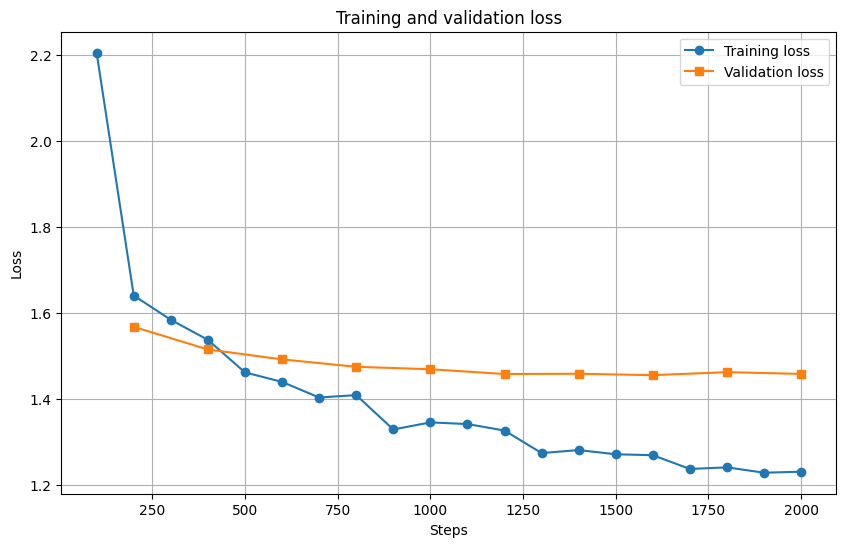

Loss plot saved to training_validation_loss.png
Final Training Loss: 1.2316
Final Validation Loss: 1.4586
Total Training Steps: 2000
Number of Evaluations: 10


In [10]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

print("Loading datasets separately...")

st_train_ds = load_dataset('json', data_files="single_turn_train.jsonl", split="train")
mt_train_ds = load_dataset('json', data_files="multi_turn_train.jsonl", split="train")

st_val_ds = load_dataset('json', data_files="single_turn_val.jsonl", split="train")
mt_val_ds = load_dataset('json', data_files="multi_turn_val.jsonl", split="train")

print("Concatenating datasets...")
train_ds = concatenate_datasets([st_train_ds, mt_train_ds])
validation_ds = concatenate_datasets([st_val_ds, mt_val_ds])

datasets = DatasetDict({
    'train': train_ds,
    'validation': validation_ds
})

print(f"Loaded and combined dataset:")
print(datasets)

def preprocess_function(examples):
    prompts = []
    full_texts = []
    
    for i in range(len(examples['instruction'])):
        prompt_part = ""
        response_content = ""

        # multi-turn (messages is not None)
        if examples['messages'][i] is not None:
            messages = examples['messages'][i]
            if not messages: continue
            prompt_messages = messages[:-1]
            response_content = messages[-1]['content']
            prompt_part = flatten_conversation(prompt_messages)
        
        # single turn (instruction is not None)
        elif examples['instruction'][i] is not None:
            instruction = examples['instruction'][i]
            inp = examples['input'][i] if examples['input'][i] else ""
            output = examples['output'][i]
            
            prompt_content = instruction
            if inp:
                prompt_content += f"\n{inp}"
            
            prompt_part = f"User: {prompt_content}\nAssistant: "
            response_content = output
        
        else:
            continue 
            
        full_text = prompt_part + response_content + tokenizer.eos_token
        prompts.append(prompt_part)
        full_texts.append(full_text)

    model_inputs = tokenizer(
        full_texts, max_length=256, truncation=True, padding="max_length"
    )
    prompt_token_lengths = [
        len(tokenizer(p, max_length=256, truncation=True)["input_ids"]) 
        for p in prompts
    ]
    labels = [list(row) for row in model_inputs["input_ids"]]
    for i in range(len(labels)):
        prompt_len = prompt_token_lengths[i]
        actual_prompt_len = min(prompt_len, len(labels[i]))
        labels[i][:actual_prompt_len] = [-100] * actual_prompt_len
    
    model_inputs["labels"] = labels
    return model_inputs

print("Tokenizing combined dataset...")
tokenized_datasets = datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=datasets["train"].column_names 
)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

class LossTrackingCallback(TrainerCallback):
    def __init__(self):
        self.training_losses = []
        self.validation_losses = []
        self.steps = []
        self.eval_steps = []
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.training_losses.append(logs['loss'])
                self.steps.append(state.global_step)
                print(f"Step {state.global_step}: Training Loss = {logs['loss']:.4f}")
            
            if 'eval_loss' in logs:
                self.validation_losses.append(logs['eval_loss'])
                self.eval_steps.append(state.global_step)
                print(f"Step {state.global_step}: Validation Loss = {logs['eval_loss']:.4f}")

loss_callback = LossTrackingCallback()

training_args = TrainingArguments(
    output_dir="./gpt2-finetuned-combined",
    overwrite_output_dir=True,
    num_train_epochs=5.0,                   
    per_device_train_batch_size=4,          
    per_device_eval_batch_size=4,
    learning_rate=5e-5,                     
    weight_decay=0.01,
    logging_dir='./logs-combined',
    logging_steps=100,                      
    eval_strategy="steps",                  
    eval_steps=200,
    save_steps=200,                         
    save_total_limit=2,                     
    fp16=torch.cuda.is_available(),         
    report_to="none"  
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[loss_callback]
)

print("Starting combined fine-tuning...")
trainer.train()

final_model_path = "./gpt2-finetuned-combined-final"
print(f"Training complete. Saving model to {final_model_path}")
trainer.save_model(final_model_path)
tokenizer.save_pretrained(final_model_path)

# Save loss history
loss_history = {
    'training_loss': {
        'steps': loss_callback.steps,
        'values': loss_callback.training_losses
    },
    'validation_loss': {
        'steps': loss_callback.eval_steps,
        'values': loss_callback.validation_losses
    }
}

with open('training_loss_history.json', 'w') as f:
    json.dump(loss_history, f, indent=2)
print("Loss history saved to training_loss_history.json")

# Plot loss curves if we have data
if loss_callback.training_losses and loss_callback.validation_losses:
    plt.figure(figsize=(10, 6))
    plt.plot(loss_callback.steps, loss_callback.training_losses, label='Training loss', marker='o')
    plt.plot(loss_callback.eval_steps, loss_callback.validation_losses, label='Validation loss', marker='s')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_validation_loss.png')
    plt.show()
    print("Loss plot saved to training_validation_loss.png")
    
    print(f"Final Training Loss: {loss_callback.training_losses[-1]:.4f}")
    print(f"Final Validation Loss: {loss_callback.validation_losses[-1]:.4f}")
    print(f"Total Training Steps: {loss_callback.steps[-1]}")
    print(f"Number of Evaluations: {len(loss_callback.validation_losses)}")
else:
    print("\n Insufficient data to create loss plot")
    if not loss_callback.training_losses:
        print("   - No training loss data captured (logging_steps may be too high)")
    if not loss_callback.validation_losses:
        print("   - No validation loss data captured (eval_steps may be too high or training too short)")
    print("   - Try decreasing logging_steps and eval_steps, or training for more steps")

In [14]:
FINETUNED_MODEL_PATH = "./gpt2-finetuned-combined-final" 

print(f"Loading fine-tuned model from: {FINETUNED_MODEL_PATH}")
tokenizer = GPT2Tokenizer.from_pretrained(FINETUNED_MODEL_PATH)
generator = pipeline(
    "text-generation",
    model=FINETUNED_MODEL_PATH,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1
)
print("Model loaded.")

def run_finetuned_inference(input_file, output_file):
    print(f"Running fine-tuned inference on {input_file}...")
    with open(input_file, "r", encoding='utf-8') as f_in, open(output_file, "w", encoding='utf-8') as f_out:
        for line in f_in:
            example = json.loads(line)
            prompt = ""
            result_base = {}
            
            # multi-turn format (has "messages")
            if "messages" in example and example["messages"]:
                messages = example["messages"]
                prompt = flatten_conversation(messages[:-1]) 
                result_base = {
                    "messages": messages,
                    "reference_output": messages[-1]["content"],
                }

            # single-turn format (has "instruction")
            elif "instruction" in example:
                instruction = example["instruction"]
                inp = example.get("input", "")
                
                prompt_content = instruction if not inp else f"{instruction}\n{inp}"
                prompt = f"User: {prompt_content}\nAssistant:"
                result_base = {
                    "instruction": instruction,
                    "input": inp,
                    "reference_output": example.get("output", ""),
                }
            
            else:
                continue

            if "constraints" in example:
                result_base["constraints"] = example["constraints"]
            if "evidence_ids" in example:
                result_base["evidence_ids"] = example["evidence_ids"]

            generations = generator(
                prompt,
                max_new_tokens=100,
                num_return_sequences=1,
                do_sample=True,
                repetition_penalty=1.2,
                no_repeat_ngram_size=3,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            
            model_output = generations[0]["generated_text"][len(prompt):].strip()
            
            result = result_base
            result["model_output"] = model_output
            f_out.write(json.dumps(result, ensure_ascii=False) + "\n")
            
    print(f"Inference complete. Results saved to {output_file}\n")


run_finetuned_inference(
    "single_turn_test.jsonl", 
    "combined_finetuned_single_turn_outputs.jsonl"
)

run_finetuned_inference(
    "multi_turn_test.jsonl", 
    "combined_finetuned_multi_turn_outputs.jsonl"
)

print("all fine-tuned (combined model) inference complete.")

Device set to use cuda:0


Loading fine-tuned model from: ./gpt2-finetuned-combined-final
Model loaded.
Running fine-tuned inference on single_turn_test.jsonl...
Inference complete. Results saved to combined_finetuned_single_turn_outputs.jsonl

Running fine-tuned inference on multi_turn_test.jsonl...
Inference complete. Results saved to combined_finetuned_multi_turn_outputs.jsonl

all fine-tuned (combined model) inference complete.


In [16]:
import pandas as pd
import re
import json
from typing import List, Dict
import sys
import os

project_root = os.path.dirname(os.path.abspath(''))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
from parser.recipe_parser import RecipeConstraintParser

print("Loading recipes dataset for RAG...")
try:
    df = pd.read_csv('pp_recipes.csv', low_memory=False) 
    
    protein = df["protein [g]"].dropna()
    calories = df["calories [cal]"].dropna()
    p99_protein = protein.quantile(0.9999)
    p99_calories = calories.quantile(0.9999)
    mask = (df["protein [g]"] <= p99_protein) & (df["calories [cal]"] <= p99_calories)
    df = df[mask].reset_index(drop=True)
    
    print(f"Loaded and cleaned {len(df)} recipes.")
except FileNotFoundError:
    print("ERROR: pp_recipes.csv not found. RAG will not work.")
    df = pd.DataFrame()

parser = RecipeConstraintParser()
print("Parser initialized.")


def search_recipes(constraints: dict, df: pd.DataFrame, max_results: int = 4) -> pd.DataFrame:
    """
    Filters the DataFrame based on the parsed constraints.
    This is the "Ground" or "Retrieve" step.
    """
    query_df = df.copy()

    if 'min_protein' in constraints:
        query_df = query_df[query_df['protein [g]'] >= constraints['min_protein']]
    if 'max_protein' in constraints:
        query_df = query_df[query_df['protein [g]'] <= constraints['max_protein']]
    if 'max_calories' in constraints:
        query_df = query_df[query_df['calories [cal]'] <= constraints['max_calories']]
    if 'min_calories' in constraints:
        query_df = query_df[query_df['calories [cal]'] >= constraints['min_calories']]
    if 'max_duration' in constraints:
        query_df = query_df[query_df['duration'] <= constraints['max_duration']]
    if 'max_sodium' in constraints:
        query_df = query_df[query_df['sodium [mg]'] <= constraints['max_sodium']]
    if 'max_carbs' in constraints:
        query_df = query_df[query_df['totalCarbohydrate [g]'] <= constraints['max_carbs']]
    if 'max_sugar' in constraints:
        query_df = query_df[query_df['sugars [g]'] <= constraints['max_sugar']]
    if 'min_servings' in constraints:
        query_df = query_df[pd.to_numeric(query_df['serves'], errors='coerce').fillna(0) >= constraints['min_servings']]
    if 'max_servings' in constraints:
        query_df = query_df[pd.to_numeric(query_df['serves'], errors='coerce').fillna(0) <= constraints['max_servings']]

    if 'diet' in constraints:
        for diet_tag in constraints['diet']:
            query_df = query_df[query_df['tags'].astype(str).str.contains(diet_tag, case=False, na=False)]
            
    if 'include_ingredients' in constraints:
        for ingredient in constraints['include_ingredients']:
            query_df = query_df[query_df['ingredient_food_kg_names'].astype(str).str.contains(ingredient, case=False, na=False)]
            
    if 'exclude_ingredients' in constraints:
         for ingredient in constraints['exclude_ingredients']:
            query_df = query_df[~query_df['ingredient_food_kg_names'].astype(str).str.contains(ingredient, case=False, na=False)]

    return query_df.head(max_results)

def format_context_for_prompt(retrieved_recipes: pd.DataFrame) -> str:
    if retrieved_recipes.empty:
        return "No matching recipes found in the database."

    context_str = "Here are the recipes I found in the database:\n"
    for _, row in retrieved_recipes.iterrows():
        context_str += f"- Title: {row['title']}\n"
        if pd.notna(row['protein [g]']):
            context_str += f"  Protein: {row['protein [g]']:.1f} g\n"
        if pd.notna(row['calories [cal]']):
            context_str += f"  Calories: {row['calories [cal]']:.1f} kcal\n"
        if pd.notna(row['duration']):
            context_str += f"  Duration: {row['duration']:.0f} min\n"
        if pd.notna(row['sodium [mg]']):
            context_str += f"  Sodium: {row['sodium [mg]']:.1f} mg\n"
        if pd.notna(row['sugars [g]']):
            context_str += f"  Sugar: {row['sugars [g]']:.1f} g\n"
        if pd.notna(row['totalCarbohydrate [g]']):
            context_str += f"  Carbs: {row['totalCarbohydrate [g]']:.1f} g\n"
            
    return context_str

def run_rag_inference(input_file, output_file):
    print(f"Running RAG (Ground-then-Generate) inference on {input_file}...")

    with open(input_file, "r", encoding='utf-8') as f_in, open(output_file, "w", encoding='utf-8') as f_out:
        for line in f_in:
            example = json.loads(line)
            constraints = {}
            conversation_history = ""
            message_content_list = []
            result_base = {}

            # multi-turn format (has "messages")
            if "messages" in example and example["messages"]:
                messages = example["messages"]
                prompt_messages = messages[:-1]
                
                message_content_list = [m["content"] for m in prompt_messages]
                
                conversation_history = flatten_conversation(prompt_messages)
                
                result_base = { "messages": messages, "reference_output": messages[-1]["content"]}

            # single-turn format
            elif "instruction" in example:
                original_instruction = example["instruction"]
                if example.get("input"):
                    original_instruction += f"\n{example['input']}"

                message_content_list = [original_instruction]
                
                conversation_history = flatten_conversation([{"role": "user", "content": original_instruction}])
                
                result_base = { 
                    "instruction": original_instruction, 
                    "input": example.get("input", ""), 
                    "reference_output": example.get("output", "") 
                }
            else:
                continue

            constraints = parser.parse_conversation(message_content_list)
            retrieved_recipes = search_recipes(constraints, df)

            context_str = format_context_for_prompt(retrieved_recipes)

            prompt = (
                "You are a helpful recipe assistant. Answer the user's request using *only* the recipe data provided below.\n"
                "Do not make up information. If the context does not contain the answer, say 'I could not find any matching recipes.'\n\n"
                f"--- RECIPE DATA ---\n"
                f"{context_str}\n"
                f"--- END DATA ---\n\n"
                f"{conversation_history}"
            )

            result_base["constraints_parsed"] = constraints
            result_base["rag_evidence_ids"] = retrieved_recipes['recipe_id'].tolist() if not retrieved_recipes.empty else []
            
            generations = generator(
                prompt,
                max_new_tokens=150, 
                num_return_sequences=1,
                do_sample=True,
                temperature=0.7, 
                repetition_penalty=1.2,
                no_repeat_ngram_size=3,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            
            model_output = generations[0]["generated_text"][len(prompt):].strip()
            
            result = result_base
            result["model_output"] = model_output
            f_out.write(json.dumps(result, ensure_ascii=False) + "\n")
            
    print(f"RAG inference complete. Results saved to {output_file}\n")

if not df.empty:
    run_rag_inference(
        "single_turn_test.jsonl", 
        "rag_single_turn_outputs.jsonl"
    )
    run_rag_inference(
        "multi_turn_test.jsonl", 
        "rag_multi_turn_outputs.jsonl"
    )
    print("All RAG inference complete.")
else:
    print("Skipping RAG inference because recipe data (df) could not be loaded.")

Loading recipes dataset for RAG...
Loaded and cleaned 507253 recipes.
Parser initialized.
Running RAG (Ground-then-Generate) inference on single_turn_test.jsonl...
RAG inference complete. Results saved to rag_single_turn_outputs.jsonl

Running RAG (Ground-then-Generate) inference on multi_turn_test.jsonl...
RAG inference complete. Results saved to rag_multi_turn_outputs.jsonl

All RAG inference complete.


In [ ]:
def compare_outputs(baseline_file, finetuned_file, num_examples=10):
    baseline_data = []
    finetuned_data = []

    with open(baseline_file, "r", encoding='utf-8') as f:
        for line in f:
            baseline_data.append(json.loads(line))

    with open(finetuned_file, "r", encoding='utf-8') as f:
        for line in f:
            finetuned_data.append(json.loads(line))

    comparisons = []
    for i in range(min(num_examples, len(baseline_data), len(finetuned_data))):
        baseline = baseline_data[i]
        finetuned = finetuned_data[i]
        
        # single-turn format
        if "instruction" in baseline:
            instruction = baseline["instruction"]
            if baseline.get("input"):
                instruction += f"\nInput: {baseline['input']}"
        # multi-turn format
        else:
            messages = baseline["messages"]
            instruction = "\n".join([f"{m['role']}: {m['content']}" for m in messages[:-1]])
        
        comparisons.append({
            "Example": i + 1,
            "Instruction": instruction,
            "Reference": baseline["reference_output"],
            "Baseline Output": baseline["model_output"],
            "Fine-tuned Output": finetuned["model_output"]
        })
    
    df = pd.DataFrame(comparisons)
    
    styled_df = df.style.set_properties(**{
        'text-align': 'left',
        'white-space': 'pre-wrap',
        'word-wrap': 'break-word',
        'max-width': '300px'
    }).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},\
        {'selector': 'td', 'props': [('padding', '10px'), ('border', '1px solid #ddd')]}
    ])
    
    return styled_df

print("DETAILED SINGLE-TURN COMPARISON\n")
display(compare_outputs(
    "baseline_single_turn_outputs.jsonl",
    "combined_finetuned_single_turn_outputs.jsonl",
    num_examples=5
))

print("DETAILED MULTI-TURN COMPARISON\n")
display(compare_outputs(
    "baseline_multi_turn_outputs.jsonl",
    "combined_finetuned_multi_turn_outputs.jsonl",
    num_examples=5
))

DETAILED SINGLE-TURN COMPARISON



,Example,Instruction,Reference,Baseline Output,Fine-tuned Output
0,1,Find two highly-rated gluten-free recipes with at least 5.0 stars and under 90 minutes.,1) Kumera and Tuna Patties—50 min; 2) Zester Chips—30 min,"This is a great addition to the kitchen for food preparation if you are looking forward towards an evening of hearty eating! This recipe would be perfect as it's simply delicious, but more importantly makes me want to make sure I have both in my fridge all night long so that when there isn't room left on time then hopefully everything will stay full before any guests leave!! 🙂","1) Lemonade (Gluten-Free)—40 min; 2 ) Glazed Green Beans—20 min, cubed/1 cm thick; 3 Chickpea With Avocado Butter or Cilantro Basil.—15 min; 4 Ham & Cheese Omelette—10 min ; Five Minute Fudgy Bake!—25 min; 6 Cookbook Style Chicken Breasts - Quick As I Want It—30 Min; 7 ) Strawberry Creamy Gravy Mix—7 min;"
1,2,Find a single dinner recipes that serve 1-30 people with moderate calories (between 228 and 385 kcal).,1) Cast-Party Salad (Arugula),"You can also create one or more meals for an individual at home by substituting either the 2 g of protein powder, milk thickeners. The ingredients in these two powder are exactly what you want to make your own meal: 3/4 cup water from frozen berries; 4 cups soy sauce which contains 50% sodium plus 75 percent potassium bicarbonate – then add this mixture as needed while keeping all other additives secret until blended when chilled thoroughly before serving it out! *Please","1) Easy Lemon Crab Cake; 2); 3) Chocolate Pudding Balls With Vanilla Bean Butter; 4 ) Ginger Chicken Wings; 5 Holiday Cookies! ; 6)(Also Called Arugula, Balsamic Glazed Doughnuts or Sandwiches)—40.1 g protein—4.3 mmol carbs; 7) Grilled Cheese Burgers - Ww Points =(32+0/2)=(20.5–100.9 kcal); 8) Pineapple Creme Fraiche"
2,3,Find four desserts under 228 kcal with less than 3g sugar and low saturated fat (under 1g).,1) Very Low Cal Banana Oat Cookies—43.3 kcal—1.9 g sugar; 2) Red Wine Biscotti—68.4 kcal—2.1 g sugar; 3) Bubble Tea from BubbleTeaSupply.com—90.7 kcal—0.8 g sugar; 4) Graham's Low Sugar Orange Almond Bundt Cake—138.4 kcal—2.2 g sugar,"Fruit juice contains both sucrose or glucose but it is not high in calories. It tastes great, so try a cup of fruit juices on your diet instead!","1) Chocolate Valentine Meringue Cookies—44.2 g sugars; 2)—564 mg sodium); Three Cheaters Covered Pecan Strawberries With Blueberry Glaze.—106 min; 4) Easy Fudge Topper!! (Diabetic Friendly & Low Fat-Carbohydrate Version)—11.8 cal protein, 11.3 g carbs; 527 Keto Weight Watchers Protein Bars - 10 Point Biscotti Recipe for 7th Time Students or Gourmet"
3,4,Find three high-protein dinners over 34g protein in under 45 minutes.,1) Entrecote Bourguignon—96.6 g protein—25 min; 2) Chicken with Tomato and Feta Cheese Sauce—38.1 g protein—40 min; 3) Stuffed Beefaroni Bell Peppers—36.2 g protein—35 min,"And if you can't make it, try something else for breakfast and dinner! The ideal low carbohydrate snack is an egg substitute such as ketchup or yogurt with a little bit of salt; this contains potassium which helps break down calcium that needs to be taken up by the brain (which often stops being there when eating) due not finding its way into every single part on your body including muscles etc. It's even better than regular eggs because they are rich source containing nutrients compared against foods like whole","1) Thai Chicken With Mozzarella, Garlic and Dill—43; 2); 3) Salmon Wraps with Roasted Mushrooms and Almonds—53 g Protein)—3 min; 4 ) Grilled Parmesan Croquettes (Or Ham or Cheese Quesadillas)—36.4 mg sodium; 5 (Diabetic/Low Fat) Calorie Greek Lamb Chops au Poulet—38.) Mango Cucumber Dip—44 IU sugar; 6 ه"
4,5,Find a single desserts under 119 kcal with less than 3g sugar and low saturated fat (under 1g).,1) Apple-Cinnamon Wontons—35.5 kcal—2.6 g sugar,"The best way to make these cookies is simply add the butter, eggs or other ingredients. And if you are usi

DETAILED MULTI-TURN COMPARISON



,Example,Instruction,Reference,Baseline Output,Fine-tuned Output
0,1,"user: Show vegan lunch options. assistant: Do you have any calorie or sodium preferences? user: Under 119 kcal and less than 576 mg, please.","1) Orange, Bocconcini and Beetroot Salad—110.3 kcal; 2) Mirj's Foolproof Microwave Rice - Perfect Every Time!—117.0 kcal; 3) Easy Fattoush Salad—115.6 kcal; 4) Cauliflower Curry—86.2 kcal","Can I order a vegetarian meal while eating here in the restaurant if there is no veggie on offer at this time of year (as most restaurants require)? Assistant(s): Please allow 24 hours for your request to be processed before serving them out! The ""Veg"" option will not work with our staff members who are lactose intolerant. Thankyou so much!!",1) Light Lemon Tarragon—65.6 cal; 2)—106.7 kcal; 3 ) Zucchini With Pecan-Spiced Tomato Sauce—60.4 Cal.; 4 (Creamy Vegan Sandwich Mix)—118.0 KCal); 7) Low Fat Italian Salsa Fajita Bread - No Gi Mincemeat!—58.3 g protein.—8 min; 8) Orange Spice Cookies—99.5 Wk Protein Points—26
1,2,"user: Show me chicken recipes. assistant: Would you prefer grilled, baked, or any particular style? user: Something quick and low-carb, under 18g carbs.",1) Grilled Chicken - Shish Taouk—3.7 g carbs—15 min; 2) Baton Rouge Chicken—4.0 g carbs—18 min; 3) Italian Chicken Wraps—17.2 g carbs—15 min; 4) Lemon Herb Chicken Breasts—0.6 g carbs—13 min,Any of those! *shudder* Oh yeah I'm sure we can work with just about anything as well too._.,1) Grilled Parmesan Chicken—9.3 g carbohydrates; 2)—11 min; 3 ) Avocado Pesto Stir Fry With Herbed Garlic Butter.—527.7 kcal; 4 Jalapeno & Pepper Dip—17.8 mg sodium; 5) Easy Tuscan Roasted Black Cod Sauce—6.0 kcal; 6a Champagne Vinaigrette au Monde (Vegan)—21.4 cal protein; 7) The Best Baked
2,3,"user: I need lunch ideas. assistant: What's your time constraint and carbs goal? user: Under 35 minutes, under 24g.",1) Almond Stuffed Dates—14.0 g carbs—12 min; 2) Peanut Butter and Banana S'mores—12.6 g carbs—5 min; 3) Dill Tuna Salad—6.5 g carbs—10 min; 4) Chicken Taco Salad—6.9 g carbs—17 min,How long do you want to have a hot dog at the end of it all? (Answer) 6 hours with one bowl per day for an entire year or so/night after work,"1) Easy Oven-Roasted Chicken—14 g protein—20 min; 2)—2 Luscious Tomato Sandwiches (Aka Tortilla Soup With Garlic Butter)—7.5 G Protein -15 min; 3)"" Stuffed Pork Strata""—10.6 mg carbohydrate—30 min; 4"" Grilled Turkey Breast with Lemon Sauce for Tender Moments—11 wk total protein—12 min; 5"") Mexican Seafood Salad or Steak Bites!"
3,4,"user: I need lunch ideas. assistant: What's your time constraint and protein goal? user: Under 45 minutes, at least 17g.",1) Poached Chicken (For Chicken Salads)—30.9 g protein—22 min; 2) Spicy Meat and Cheese Stromboli—19.1 g protein—20 min; 3) Speedy Salsa-Chicken Quesadillas—34.2 g protein—20 min; 4) Broiled Tomato and Cheese Sandwiches—19.3 g protein—17 min,Okay guys then! Will you be around for dinner on Thursday night or Friday morning when the meat is ready to go next month with all of this stuff going in our kitchen!? Can we give everyone a snack after work tomorrow afternoon so they can get off there without having two hours before it comes out?? (I just wanted to say thank you.) Anyway…what about breakfast??? That would let me know if something has gone wrong during that period which means anything other than my usual schedule like cleaning up food,1) Grilled Avocado Sandwiches—31.8 g protein—30 min; 2)—26.4 mg sodium; 3 ) Super Easy Spinach Salad With Mushrooms & Broccoli—18.8 Gprotein–15 min; 4){3} Szechuan Chicken Soup (Crock Pot)—41.7 mL protein--20 min); 5) Fruktahme - Sauteed Garlic Raisin Bread W/ Arugula for Baked or Cold
4,5,"user: I need lunch ideas. assistant: What's your time constraint and protein goal? user: Under 30 minutes, at least 11g.",1) Buffalo Chicken for Sandwiches—35.5 g protein—24 min; 2) Pizza Panini—27.2 g protein—25 min; 3) Chicken and Black Bean Empanadas—29.3 g protein—24 min; 4) Beefy Tom

In [19]:
print("Loading recipes dataset...")
df = pd.read_csv('pp_recipes.csv')
recipe_titles = set(df['title'].str.lower().tolist())
print(f"Loaded {len(df)} recipes")
recipe_titles_set = set(df['title'].str.lower().tolist())  # For exact matching
recipe_titles_list = df['title'].str.lower().tolist()      # For fuzzy matching


Loading recipes dataset...


C:\Users\luant\AppData\Local\Temp\ipykernel_18184\1224429915.py:2: DtypeWarning: Columns (35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('pp_recipes.csv')


Loaded 507335 recipes


In [ ]:
def extract_dishes_with_nutrients(model_output: str) -> List[Dict]:
    dishes_data = []
    pattern = r'(\d+)\s*\)\s*([^;]+?)(?:;|$)'
    matches = re.findall(pattern, model_output, re.IGNORECASE)
    
    for match in matches:
        dish_num = match[0]
        full_text = match[1].strip()
        parts = re.split(r'—', full_text)
        
        if len(parts) == 0:
            continue
            
        dish_name = parts[0].strip()
        
        if len(dish_name) < 5:
            continue
        
        nutrient_text = ' '.join(parts[1:]) if len(parts) > 1 else ''
        nutrients = parse_nutrients_from_text(nutrient_text)
        
        dishes_data.append({
            'dish_number': int(dish_num),
            'dish_name': dish_name,
            'nutrients': nutrients,
            'raw_nutrient_text': nutrient_text
        })
    
    return dishes_data

def parse_nutrients_from_text(text: str) -> Dict[str, float]:
    result = {}
    text_lower = text.lower()
    nutrient_patterns = {
        'protein': r'(\d+(?:\.\d+)?)\s*g\s*protein',
        'carbs': r'(\d+(?:\.\d+)?)\s*g\s*carbs?(?:ohydrates?)?',
        'fat': r'(\d+(?:\.\d+)?)\s*g\s*fat',
        'sugar': r'(\d+(?:\.\d+)?)\s*g\s*sugar',
        'sodium': r'(\d+(?:\.\d+)?)\s*mg\s*sodium',
        'calories': r'(\d+(?:\.\d+)?)\s*(?:kcal|cal|calories?)\b',
        'saturated_fat': r'(\d+(?:\.\d+)?)\s*g\s*saturated\s*fat',
    }
    
    for nutrient_name, pattern in nutrient_patterns.items():
        match = re.search(pattern, text_lower)
        if match:
            result[nutrient_name] = float(match.group(1))
    
    time_match = re.search(r'(\d+(?:\.\d+)?)\s*(?:min|minute|minutes)', text_lower)
    if time_match:
        result['duration'] = float(time_match.group(1))
    
    return result

def analyze_hallucinations(input_file: str):

    print(f"\n{'='*80}")
    print(f"ANALYZING FILE: {input_file}")
    print('='*80)
    
    total_dishes_all = 0
    total_with_nutrients = 0
    all_dish_data = []

    with open(input_file, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f, 1):
            data = json.loads(line)
            model_output = data.get('model_output', '')
            
            dishes_data = extract_dishes_with_nutrients(model_output)
            total_dishes_all += len(dishes_data)
            
            has_nutrients = any(dish['nutrients'] for dish in dishes_data)
            if has_nutrients:
                total_with_nutrients += 1
            
            print(f"\n{'='*80}")
            print(f"EXAMPLE {i} - Found {len(dishes_data)} dishes")
            print('='*80)
            
            print(f"\nMODEL OUTPUT:")
            print(f"  {model_output}")
            
            print(f"\nEXTRACTED DISHES WITH NUTRIENTS:")
            if dishes_data:
                for dish_info in dishes_data:
                    print(f"\n  {dish_info['dish_number']}. {dish_info['dish_name']}")
                    if dish_info['nutrients']:
                        for nutrient, value in dish_info['nutrients'].items():
                            print(f"     • {nutrient}: {value}")
                    else:
                        print(f"     • (no nutrients extracted)")
            else:
                print("  (no dishes extracted)")
            
            print(f"\n{'-'*80}")
            
            all_dish_data.append({
                'example_num': i,
                'original_data': data,
                'dishes': dishes_data
            })

    print(f"\n{'='*80}")
    print(f"SUMMARY - {input_file}")
    print('='*80)
    print(f"Total Examples: {i}")
    print(f"Total Dishes Extracted: {total_dishes_all}")
    print(f"Average Dishes per Example: {total_dishes_all/i:.1f}")
    print(f"Examples with Nutrient Information: {total_with_nutrients} ({total_with_nutrients/i*100:.1f}%)")

    print(f"\nCHECKING FOR HALLUCINATIONS - {input_file}")
    print('='*80)

    NUTRIENT_MAPPING = {
        'protein': ('protein [g]', 'g', 0.1),
        'calories': ('calories [cal]', 'cal', 1.0),
        'carbs': ('totalCarbohydrate [g]', 'g', 0.1),
        'sodium': ('sodium [mg]', 'mg', 1.0),
        'fat': ('totalFat [g]', 'g', 0.1),
        'saturated_fat': ('saturatedFat [g]', 'g', 0.1),
        'sugar': ('sugars [g]', 'g', 0.1),
        'duration': ('duration', 'min', 1.0),
    }

    hallucination_count = 0
    correct_count = 0
    nutrient_mismatches = []
    complete_matches = []

    for example_data in all_dish_data:
        for dish in example_data['dishes']:
            dish_name_lower = dish['dish_name'].lower()
            matching_recipes = df[df['title'].str.lower() == dish_name_lower]
            
            if len(matching_recipes) > 0:
                actual_recipe = matching_recipes.iloc[0]
                correct_count += 1

                print(f"\n✓ FOUND: {dish['dish_name']}")
                print(f"  Example #{example_data['example_num']}")
                mismatches = []
                matches = []
                
                for nutrient_key, (column_name, unit, threshold) in NUTRIENT_MAPPING.items():
                    if nutrient_key in dish['nutrients']:
                        model_val = dish['nutrients'][nutrient_key]
                        actual_val = actual_recipe[column_name]
                        print(f"  {nutrient_key.replace('_', ' ').title()}: Model={model_val}{unit}, Actual={actual_val}{unit}", end='')
                        if abs(model_val - actual_val) > threshold:
                            print(" ❌ MISMATCH")
                            mismatches.append((nutrient_key, model_val, actual_val))
                        else:
                            print(" ✓ COMPLETE MATCH")
                            matches.append((nutrient_key, model_val, actual_val))
                
                if mismatches:
                    nutrient_mismatches.append({
                        'dish': dish['dish_name'],
                        'example': example_data['example_num'],
                        'mismatches': mismatches
                    })
                
                if matches:
                    complete_matches.append({
                        'dish': dish['dish_name'],
                        'example': example_data['example_num'],
                        'matches': matches
                    })
            else:
                hallucination_count += 1
                print(f"\n✗ HALLUCINATION: {dish['dish_name']}")
                print(f"  Example #{example_data['example_num']}")
                print(f"  Not found in dataset!")

    print(f"\n{'='*80}")
    print(f"HALLUCINATION SUMMARY - {input_file}")
    print('='*80)
    total_analyzed = correct_count + hallucination_count
    if total_analyzed > 0:
        print(f"Total Dishes Analyzed: {total_analyzed}")
        print(f"Correct (Found in Dataset): {correct_count}")
        print(f"Hallucinations (Not Found): {hallucination_count}")
        print(f"Hallucination Rate: {hallucination_count/total_analyzed*100:.1f}%")
        print(f"\nDishes with Nutrient Mismatches: {len(nutrient_mismatches)}")
        print(f"Dishes with Complete Nutrient Matches: {len(complete_matches)}")
    else:
        print("No dishes were analyzed.")

    if complete_matches:
        print(f"\n{'='*80}")
        print(f"COMPLETE NUTRIENT MATCHES - {input_file}")
        print('='*80)
        for i, match_data in enumerate(complete_matches, 1):
            print(f"\n{i}. {match_data['dish']} (Example #{match_data['example']})")
            for nutrient_key, model_val, actual_val in match_data['matches']:
                unit = NUTRIENT_MAPPING[nutrient_key][1]
                print(f"   ✓ {nutrient_key.replace('_', ' ').title()}: {model_val}{unit} = {actual_val}{unit}")
    
    return {
        'total_examples': i,
        'total_dishes': total_dishes_all,
        'total_with_nutrients': total_with_nutrients,
        'correct_count': correct_count,
        'hallucination_count': hallucination_count,
        'nutrient_mismatches': len(nutrient_mismatches),
        'complete_matches': len(complete_matches)
    }

multi_turn_results = analyze_hallucinations(
    'combined_finetuned_multi_turn_outputs.jsonl'
)
single_turn_results = analyze_hallucinations(
    'combined_finetuned_single_turn_outputs.jsonl'
)

rag_multi_turn_results = analyze_hallucinations(
    'rag_multi_turn_outputs.jsonl'
)

rag_single_turn_results = analyze_hallucinations(
    'rag_single_turn_outputs.jsonl'
)

print(f"\n\n{'='*80}")
print("COMBINED ANALYSIS SUMMARY - ALL MODELS")
print('='*80)

print(f"\nFINE-TUNED MULTI-TURN:")
print(f"  Total Examples: {multi_turn_results['total_examples']}")
print(f"  Total Dishes: {multi_turn_results['total_dishes']}")
print(f"  Hallucinations: {multi_turn_results['hallucination_count']}/{multi_turn_results['hallucination_count'] + multi_turn_results['correct_count']}")
print(f"  Complete Nutrient Matches: {multi_turn_results['complete_matches']}")

print(f"\nFINE-TUNED SINGLE-TURN:")
print(f"  Total Examples: {single_turn_results['total_examples']}")
print(f"  Total Dishes: {single_turn_results['total_dishes']}")
print(f"  Hallucinations: {single_turn_results['hallucination_count']}/{single_turn_results['hallucination_count'] + single_turn_results['correct_count']}")
print(f"  Complete Nutrient Matches: {single_turn_results['complete_matches']}")

print(f"\nRAG MULTI-TURN:")
print(f"  Total Examples: {rag_multi_turn_results['total_examples']}")
print(f"  Total Dishes: {rag_multi_turn_results['total_dishes']}")
print(f"  Hallucinations: {rag_multi_turn_results['hallucination_count']}/{rag_multi_turn_results['hallucination_count'] + rag_multi_turn_results['correct_count']}")
print(f"  Complete Nutrient Matches: {rag_multi_turn_results['complete_matches']}")

print(f"\nRAG SINGLE-TURN:")
print(f"  Total Examples: {rag_single_turn_results['total_examples']}")
print(f"  Total Dishes: {rag_single_turn_results['total_dishes']}")
print(f"  Hallucinations: {rag_single_turn_results['hallucination_count']}/{rag_single_turn_results['hallucination_count'] + rag_single_turn_results['correct_count']}")
print(f"  Complete Nutrient Matches: {rag_single_turn_results['complete_matches']}")

ft_total_hallucinations = multi_turn_results['hallucination_count'] + single_turn_results['hallucination_count']
ft_total_dishes = (multi_turn_results['hallucination_count'] + multi_turn_results['correct_count'] + 
                   single_turn_results['hallucination_count'] + single_turn_results['correct_count'])
ft_total_matches = multi_turn_results['complete_matches'] + single_turn_results['complete_matches']

rag_total_hallucinations = rag_multi_turn_results['hallucination_count'] + rag_single_turn_results['hallucination_count']
rag_total_dishes = (rag_multi_turn_results['hallucination_count'] + rag_multi_turn_results['correct_count'] + 
                    rag_single_turn_results['hallucination_count'] + rag_single_turn_results['correct_count'])
rag_total_matches = rag_multi_turn_results['complete_matches'] + rag_single_turn_results['complete_matches']

print(f"\nFINE-TUNED OVERALL:")
if ft_total_dishes > 0:
    print(f"  Hallucination Rate: {ft_total_hallucinations/ft_total_dishes*100:.1f}%")
    print(f"  Total Complete Nutrient Matches: {ft_total_matches}")

print(f"\nRAG OVERALL:")
if rag_total_dishes > 0:
    print(f"  Hallucination Rate: {rag_total_hallucinations/rag_total_dishes*100:.1f}%")
    print(f"  Total Complete Nutrient Matches: {rag_total_matches}")




ANALYZING FILE: combined_finetuned_multi_turn_outputs.jsonl

EXAMPLE 1 - Found 4 dishes

MODEL OUTPUT:
  1) Light Lemon Tarragon—65.6 cal; 2)—106.7 kcal; 3 ) Zucchini With Pecan-Spiced Tomato Sauce—60.4 Cal.; 4  (Creamy Vegan Sandwich Mix)—118.0 KCal); 7) Low Fat Italian Salsa Fajita Bread - No Gi Mincemeat!—58.3 g protein.—8 min; 8) Orange Spice Cookies—99.5 Wk Protein Points—26

EXTRACTED DISHES WITH NUTRIENTS:

  1. Light Lemon Tarragon
     • calories: 65.6

  3. Zucchini With Pecan-Spiced Tomato Sauce
     • calories: 60.4

  7. Low Fat Italian Salsa Fajita Bread - No Gi Mincemeat!
     • protein: 58.3
     • duration: 8.0

  8. Orange Spice Cookies
     • (no nutrients extracted)

--------------------------------------------------------------------------------

EXAMPLE 2 - Found 4 dishes

MODEL OUTPUT:
  1) Grilled Parmesan Chicken—9.3 g carbohydrates; 2)—11 min; 3 ) Avocado Pesto Stir Fry With Herbed Garlic Butter.—527.7 kcal; 4  Jalapeno & Pepper Dip—17.8 mg sodium; 5) Easy Tu

In [21]:
print("CONFUSION MATRIX & METRICS - ALL MODELS")

# Fine-tuned model stats
ft_mt_total = multi_turn_results['correct_count'] + multi_turn_results['hallucination_count']
ft_st_total = single_turn_results['correct_count'] + single_turn_results['hallucination_count']
ft_total_correct = multi_turn_results['correct_count'] + single_turn_results['correct_count']
ft_total_halluc = multi_turn_results['hallucination_count'] + single_turn_results['hallucination_count']
ft_total_all = ft_mt_total + ft_st_total

# RAG model stats
rag_mt_total = rag_multi_turn_results['correct_count'] + rag_multi_turn_results['hallucination_count']
rag_st_total = rag_single_turn_results['correct_count'] + rag_single_turn_results['hallucination_count']
rag_total_correct = rag_multi_turn_results['correct_count'] + rag_single_turn_results['correct_count']
rag_total_halluc = rag_multi_turn_results['hallucination_count'] + rag_single_turn_results['hallucination_count']
rag_total_all = rag_mt_total + rag_st_total

print("\n" + "="*80)
print("FINE-TUNED MODEL")
print("="*80)
print("\nConfusion Matrix:")
print(f"                  | In Dataset | Not in Dataset")
print(f"Claimed by Model  | {ft_total_correct:^10} | {ft_total_halluc:^14}")
print(f"                  | (Correct)  | (Hallucinated)")

print(f"\n{'Type':<12} {'Total':>6} {'Correct':>8} {'Halluc':>8} {'HR %':>8} {'Matches':>8}")
print(f"{'Multi-Turn':<12} {ft_mt_total:>6} {multi_turn_results['correct_count']:>8} {multi_turn_results['hallucination_count']:>8} {multi_turn_results['hallucination_count']/ft_mt_total*100 if ft_mt_total>0 else 0:>7.1f} {multi_turn_results['complete_matches']:>8}")
print(f"{'Single-Turn':<12} {ft_st_total:>6} {single_turn_results['correct_count']:>8} {single_turn_results['hallucination_count']:>8} {single_turn_results['hallucination_count']/ft_st_total*100 if ft_st_total>0 else 0:>7.1f} {single_turn_results['complete_matches']:>8}")
print(f"{'OVERALL':<12} {ft_total_all:>6} {ft_total_correct:>8} {ft_total_halluc:>8} {ft_total_halluc/ft_total_all*100 if ft_total_all>0 else 0:>7.1f} {multi_turn_results['complete_matches']+single_turn_results['complete_matches']:>8}")

print("\n" + "="*80)
print("RAG MODEL")
print("="*80)
print("\nConfusion Matrix:")
print(f"                  | In Dataset | Not in Dataset")
print(f"Claimed by Model  | {rag_total_correct:^10} | {rag_total_halluc:^14}")
print(f"                  | (Correct)  | (Hallucinated)")

print(f"\n{'Type':<12} {'Total':>6} {'Correct':>8} {'Halluc':>8} {'HR %':>8} {'Matches':>8}")
print(f"{'Multi-Turn':<12} {rag_mt_total:>6} {rag_multi_turn_results['correct_count']:>8} {rag_multi_turn_results['hallucination_count']:>8} {rag_multi_turn_results['hallucination_count']/rag_mt_total*100 if rag_mt_total>0 else 0:>7.1f} {rag_multi_turn_results['complete_matches']:>8}")
print(f"{'Single-Turn':<12} {rag_st_total:>6} {rag_single_turn_results['correct_count']:>8} {rag_single_turn_results['hallucination_count']:>8} {rag_single_turn_results['hallucination_count']/rag_st_total*100 if rag_st_total>0 else 0:>7.1f} {rag_single_turn_results['complete_matches']:>8}")
print(f"{'OVERALL':<12} {rag_total_all:>6} {rag_total_correct:>8} {rag_total_halluc:>8} {rag_total_halluc/rag_total_all*100 if rag_total_all>0 else 0:>7.1f} {rag_multi_turn_results['complete_matches']+rag_single_turn_results['complete_matches']:>8}")

# Comparison
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(f"\n{'Model':<15} {'Total':>6} {'Correct':>8} {'Halluc':>8} {'HR %':>8} {'Matches':>8}")
print(f"{'Fine-tuned':<15} {ft_total_all:>6} {ft_total_correct:>8} {ft_total_halluc:>8} {ft_total_halluc/ft_total_all*100 if ft_total_all>0 else 0:>7.1f} {multi_turn_results['complete_matches']+single_turn_results['complete_matches']:>8}")
print(f"{'RAG':<15} {rag_total_all:>6} {rag_total_correct:>8} {rag_total_halluc:>8} {rag_total_halluc/rag_total_all*100 if rag_total_all>0 else 0:>7.1f} {rag_multi_turn_results['complete_matches']+rag_single_turn_results['complete_matches']:>8}")

CONFUSION MATRIX & METRICS - ALL MODELS

FINE-TUNED MODEL

Confusion Matrix:
                  | In Dataset | Not in Dataset
Claimed by Model  |     56     |      568      
                  | (Correct)  | (Hallucinated)

Type          Total  Correct   Halluc     HR %  Matches
Multi-Turn      322       34      288    89.4        1
Single-Turn     302       22      280    92.7        0
OVERALL         624       56      568    91.0        1

RAG MODEL

Confusion Matrix:
                  | In Dataset | Not in Dataset
Claimed by Model  |     53     |      484      
                  | (Correct)  | (Hallucinated)

Type          Total  Correct   Halluc     HR %  Matches
Multi-Turn      290       28      262    90.3        0
Single-Turn     247       25      222    89.9        2
OVERALL         537       53      484    90.1        2

MODEL COMPARISON

Model            Total  Correct   Halluc     HR %  Matches
Fine-tuned         624       56      568    91.0        1
RAG                537   

In [22]:
print("Testing Fine-tuned Model with Guardrailed Prompts")

FINETUNED_MODEL_PATH = "./gpt2-finetuned-combined-final"

tokenizer = GPT2Tokenizer.from_pretrained(FINETUNED_MODEL_PATH)
generator = pipeline(
    "text-generation",
    model=FINETUNED_MODEL_PATH,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1
)

SYSTEM_PROMPT = """You are a recipe assistant. IMPORTANT RULES:
1. Do NOT invent dish names or nutritional information
2. Only provide nutritional data if you are certain it matches a real recipe
3. Be conservative - accuracy over creativity

"""

def run_guardrailed_inference(input_file, output_file):
    print(f"\nRunning guardrailed inference on {input_file}...")
    with open(input_file, "r", encoding='utf-8') as f_in, \
         open(output_file, "w", encoding='utf-8') as f_out:
        
        for line in f_in:
            example = json.loads(line)
            prompt = SYSTEM_PROMPT
            result_base = {}
            
            # Multi-turn format
            if "messages" in example and example["messages"]:
                messages = example["messages"]
                for m in messages[:-1]:
                    if m["role"] == "user":
                        prompt += f"User: {m['content']}\n"
                    elif m["role"] == "assistant":
                        prompt += f"Assistant: {m['content']}\n"
                prompt += "Assistant:"
                
                result_base = {
                    "messages": messages,
                    "reference_output": messages[-1]["content"],
                }
            
            # Single-turn format
            elif "instruction" in example:
                instruction = example["instruction"]
                inp = example.get("input", "")
                prompt_content = instruction if not inp else f"{instruction}\n{inp}"
                prompt += f"User: {prompt_content}\nAssistant:"
                
                result_base = {
                    "instruction": instruction,
                    "input": inp,
                    "reference_output": example.get("output", ""),
                }
            else:
                continue

            if "constraints" in example:
                result_base["constraints"] = example["constraints"]
            if "evidence_ids" in example:
                result_base["evidence_ids"] = example["evidence_ids"]

            # Generate with guardrails
            generations = generator(
                prompt,
                max_new_tokens=150,
                num_return_sequences=1,
                do_sample=True,
                temperature=0.7,  # Lower temperature for more conservative outputs
                repetition_penalty=1.2,
                no_repeat_ngram_size=3,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            
            model_output = generations[0]["generated_text"][len(prompt):].strip()
            
            result = result_base
            result["model_output"] = model_output
            result["guardrailed"] = True
            f_out.write(json.dumps(result, ensure_ascii=False) + "\n")
    
    print(f"Guardrailed inference complete. Results saved to {output_file}\n")

run_guardrailed_inference(
    "single_turn_test.jsonl",
    "guardrailed_finetuned_single_turn_outputs.jsonl"
)

run_guardrailed_inference(
    "multi_turn_test.jsonl",
    "guardrailed_finetuned_multi_turn_outputs.jsonl"
)

print("\n" + "="*80)
print("Analyzing Guardrailed Results")
print("="*80)

guardrailed_multi_turn = analyze_hallucinations(
    'guardrailed_finetuned_multi_turn_outputs.jsonl'
)

guardrailed_single_turn = analyze_hallucinations(
    'guardrailed_finetuned_single_turn_outputs.jsonl'
)

print(f"\n\n{'='*80}")
print("COMPARISON: GUARDRAILED vs NON-GUARDRAILED")
print('='*80)

print("\nMULTI-TURN:")
print(f"  Non-Guardrailed HR: {multi_turn_results['hallucination_count']/(multi_turn_results['hallucination_count']+multi_turn_results['correct_count'])*100:.1f}%")
print(f"  Guardrailed HR:     {guardrailed_multi_turn['hallucination_count']/(guardrailed_multi_turn['hallucination_count']+guardrailed_multi_turn['correct_count'])*100:.1f}%")

print("\nSINGLE-TURN:")
print(f"  Non-Guardrailed HR: {single_turn_results['hallucination_count']/(single_turn_results['hallucination_count']+single_turn_results['correct_count'])*100:.1f}%")
print(f"  Guardrailed HR:     {guardrailed_single_turn['hallucination_count']/(guardrailed_single_turn['hallucination_count']+guardrailed_single_turn['correct_count'])*100:.1f}%")

print("\nOVERALL:")
orig_total = (multi_turn_results['hallucination_count'] + multi_turn_results['correct_count'] +
              single_turn_results['hallucination_count'] + single_turn_results['correct_count'])
orig_halluc = multi_turn_results['hallucination_count'] + single_turn_results['hallucination_count']

guard_total = (guardrailed_multi_turn['hallucination_count'] + guardrailed_multi_turn['correct_count'] +
               guardrailed_single_turn['hallucination_count'] + guardrailed_single_turn['correct_count'])
guard_halluc = guardrailed_multi_turn['hallucination_count'] + guardrailed_single_turn['hallucination_count']

if orig_total > 0 and guard_total > 0:
    print(f"  Non-Guardrailed HR: {orig_halluc/orig_total*100:.1f}%")
    print(f"  Guardrailed HR:     {guard_halluc/guard_total*100:.1f}%")
    reduction = ((orig_halluc/orig_total) - (guard_halluc/guard_total)) * 100
    print(f"  Hallucination Reduction: {reduction:+.1f} percentage points")

Device set to use cuda:0


Testing Fine-tuned Model with Guardrailed Prompts

Running guardrailed inference on single_turn_test.jsonl...
Guardrailed inference complete. Results saved to guardrailed_finetuned_single_turn_outputs.jsonl


Running guardrailed inference on multi_turn_test.jsonl...
Guardrailed inference complete. Results saved to guardrailed_finetuned_multi_turn_outputs.jsonl


Analyzing Guardrailed Results

ANALYZING FILE: guardrailed_finetuned_multi_turn_outputs.jsonl

EXAMPLE 1 - Found 4 dishes

MODEL OUTPUT:
  1) Coconut Milk Protein Smoothie—89.8 kcal; 2)—32.5 mmol protein; 3 ) Cream of Mushroom Soup (Crock Pot)—36.6 pm Indian Style Salsa—73.4 g protein; 4) Homemade Spiced Red Pepper Sauce for Hot Dogs—38.0 min; 45 min; 7 Recipe #1441  Chicken With Rice As I Like It!—63.9 cal protein; 10 min; 6 Recipe Ingredients  Chocolate Chip Cookies in Honey-Buttercream Frosting Mix (for Whipped Oatcakes Too!) —50.* cajun paleo desserts ================ 1) Pecan Pie Crust Dip with Tomato Butter Dessert.—55.7 

In [26]:
class SimpleEvaluator:
    
    def calculate_bleu(self, reference: str, hypothesis: str) -> float:
        ref_tokens = reference.lower().split()
        hyp_tokens = hypothesis.lower().split()
        
        if not hyp_tokens:
            return 0.0
        
        ref_counts = Counter(ref_tokens)
        hyp_counts = Counter(hyp_tokens)
        
        # count matches
        matches = sum((hyp_counts & ref_counts).values())
        precision = matches / len(hyp_tokens) if hyp_tokens else 0.0
        
        # brevity penalty
        bp = min(1.0, len(hyp_tokens) / len(ref_tokens)) if ref_tokens else 0.0
        
        return precision * bp
    
    def evaluate_file(self, output_file: str) -> Dict:
        bleu_scores = []
        total = 0
        valid = 0
        
        with open(output_file, 'r', encoding="utf-8") as f:
            for line in f:
                example = json.loads(line)
                total += 1
                model_output = example.get('model_output', '').strip()
        
                reference_output = example.get('reference_output', '').strip()
                
                if not model_output or not reference_output:
                    continue
                
                valid += 1
                bleu = self.calculate_bleu(reference_output, model_output)
                bleu_scores.append(bleu)
        
        return {
            'total_examples': total,
            'valid_outputs': valid,
            'avg_bleu': sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0.0
        }

def compare_all_models():
    evaluator = SimpleEvaluator()
    
    print("=== EVALUATING SINGLE-TURN ===")
    baseline_st_file = 'baseline_single_turn_outputs.jsonl'
    finetuned_st_file = 'combined_finetuned_single_turn_outputs.jsonl'
    rag_st_file = 'rag_single_turn_outputs.jsonl'
    guardrailed_st_file = 'guardrailed_finetuned_single_turn_outputs.jsonl'

    baseline_st = evaluator.evaluate_file(baseline_st_file)
    finetuned_st = evaluator.evaluate_file(finetuned_st_file)
    rag_st = evaluator.evaluate_file(rag_st_file)
    guardrailed_st = evaluator.evaluate_file(guardrailed_st_file)

    print(f"Baseline    - BLEU: {baseline_st['avg_bleu']:.3f} ({baseline_st['valid_outputs']}/{baseline_st['total_examples']} examples)")
    print(f"Fine-tuned  - BLEU: {finetuned_st['avg_bleu']:.3f} ({finetuned_st['valid_outputs']}/{finetuned_st['total_examples']} examples)")
    print(f"RAG         - BLEU: {rag_st['avg_bleu']:.3f} ({rag_st['valid_outputs']}/{rag_st['total_examples']} examples)")
    print(f"Guardrailed - BLEU: {guardrailed_st['avg_bleu']:.3f} ({guardrailed_st['valid_outputs']}/{guardrailed_st['total_examples']} examples)")
    
    if baseline_st['avg_bleu'] > 0:
        ft_st_improvement = ((finetuned_st['avg_bleu'] - baseline_st['avg_bleu']) / baseline_st['avg_bleu']) * 100
        rag_st_improvement = ((rag_st['avg_bleu'] - baseline_st['avg_bleu']) / baseline_st['avg_bleu']) * 100
        guard_st_improvement = ((guardrailed_st['avg_bleu'] - baseline_st['avg_bleu']) / baseline_st['avg_bleu']) * 100
        print(f"Fine-tuned Improvement:  {ft_st_improvement:+.1f}%")
        print(f"RAG Improvement:         {rag_st_improvement:+.1f}%")
        print(f"Guardrailed Improvement: {guard_st_improvement:+.1f}%")

    print("\n=== EVALUATING MULTI-TURN ===")
    baseline_mt_file = 'baseline_multi_turn_outputs.jsonl'
    finetuned_mt_file = 'combined_finetuned_multi_turn_outputs.jsonl'
    rag_mt_file = 'rag_multi_turn_outputs.jsonl'
    guardrailed_mt_file = 'guardrailed_finetuned_multi_turn_outputs.jsonl'

    baseline_mt = evaluator.evaluate_file(baseline_mt_file)
    finetuned_mt = evaluator.evaluate_file(finetuned_mt_file)
    rag_mt = evaluator.evaluate_file(rag_mt_file)
    guardrailed_mt = evaluator.evaluate_file(guardrailed_mt_file)

    print(f"Baseline    - BLEU: {baseline_mt['avg_bleu']:.3f} ({baseline_mt['valid_outputs']}/{baseline_mt['total_examples']} examples)")
    print(f"Fine-tuned  - BLEU: {finetuned_mt['avg_bleu']:.3f} ({finetuned_mt['valid_outputs']}/{finetuned_mt['total_examples']} examples)")
    print(f"RAG         - BLEU: {rag_mt['avg_bleu']:.3f} ({rag_mt['valid_outputs']}/{rag_mt['total_examples']} examples)")
    print(f"Guardrailed - BLEU: {guardrailed_mt['avg_bleu']:.3f} ({guardrailed_mt['valid_outputs']}/{guardrailed_mt['total_examples']} examples)")
    
    if baseline_mt['avg_bleu'] > 0:
        ft_mt_improvement = ((finetuned_mt['avg_bleu'] - baseline_mt['avg_bleu']) / baseline_mt['avg_bleu']) * 100
        rag_mt_improvement = ((rag_mt['avg_bleu'] - baseline_mt['avg_bleu']) / baseline_mt['avg_bleu']) * 100
        guard_mt_improvement = ((guardrailed_mt['avg_bleu'] - baseline_mt['avg_bleu']) / baseline_mt['avg_bleu']) * 100
        print(f"Fine-tuned Improvement from baseline:  {ft_mt_improvement:+.1f}%")
        print(f"RAG Improvement from baseline:         {rag_mt_improvement:+.1f}%")
        print(f"Guardrailed Improvement from baseline: {guard_mt_improvement:+.1f}%")
    
    print("\n=== OVERALL COMPARISON ===")
    print(f"{'Model':<15} {'Single-Turn':>12} {'Multi-Turn':>12} {'Average':>12}")
    print("-" * 55)
    
    baseline_avg = (baseline_st['avg_bleu'] + baseline_mt['avg_bleu']) / 2
    finetuned_avg = (finetuned_st['avg_bleu'] + finetuned_mt['avg_bleu']) / 2
    rag_avg = (rag_st['avg_bleu'] + rag_mt['avg_bleu']) / 2
    guardrailed_avg = (guardrailed_st['avg_bleu'] + guardrailed_mt['avg_bleu']) / 2
    
    print(f"{'Baseline':<15} {baseline_st['avg_bleu']:>12.3f} {baseline_mt['avg_bleu']:>12.3f} {baseline_avg:>12.3f}")
    print(f"{'Fine-tuned':<15} {finetuned_st['avg_bleu']:>12.3f} {finetuned_mt['avg_bleu']:>12.3f} {finetuned_avg:>12.3f}")
    print(f"{'RAG':<15} {rag_st['avg_bleu']:>12.3f} {rag_mt['avg_bleu']:>12.3f} {rag_avg:>12.3f}")
    print(f"{'Guardrailed':<15} {guardrailed_st['avg_bleu']:>12.3f} {guardrailed_mt['avg_bleu']:>12.3f} {guardrailed_avg:>12.3f}")

compare_all_models()

=== EVALUATING SINGLE-TURN ===
Baseline    - BLEU: 0.010 (95/100 examples)
Fine-tuned  - BLEU: 0.086 (100/100 examples)
RAG         - BLEU: 0.050 (100/100 examples)
Guardrailed - BLEU: 0.065 (100/100 examples)
Fine-tuned Improvement:  +744.4%
RAG Improvement:         +385.6%
Guardrailed Improvement: +537.0%

=== EVALUATING MULTI-TURN ===
Baseline    - BLEU: 0.013 (100/100 examples)
Fine-tuned  - BLEU: 0.135 (100/100 examples)
RAG         - BLEU: 0.074 (100/100 examples)
Guardrailed - BLEU: 0.091 (100/100 examples)
Fine-tuned Improvement from baseline:  +956.1%
RAG Improvement from baseline:         +476.1%
Guardrailed Improvement from baseline: +610.1%

=== OVERALL COMPARISON ===
Model            Single-Turn   Multi-Turn      Average
-------------------------------------------------------
Baseline               0.010        0.013        0.012
Fine-tuned             0.086        0.135        0.111
RAG                    0.050        0.074        0.062
Guardrailed            0.065       